In [25]:
#####Sparse Factorization Machines#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy
import scipy.linalg
import scipy.stats as ss
import itertools
from numpy.random import *
from scipy import optimize
from scipy.stats import norm
from scipy import sparse

In [26]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) > np.random.rand(n).reshape(n, 1)), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

In [27]:
####データの発生####
##データの設定
k = 10   #基底数
item = 3000   #アイテム数
tag = 200   #タグ数
pt = np.random.poisson(np.random.gamma(30.0, 1/0.25, item), item)   #アイテムあたりの購買数
pt[pt < 2] = 2
N = np.sum(pt)   #総レコード数
n = np.random.poisson(1.75, item); n[n==0] = 1   #アイテムごとのタグ数
vec_k = np.repeat(1, k)

In [28]:
##IDとインデックスの設定
#IDの設定
item_id = np.repeat(range(item), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(item)])))

#インデックスの設定
index = np.arange(N)
item_list = [i for i in range(item)]
for i in range(item):
    item_list[i] = index[item_id==i]

In [29]:
##階層モデルの説明変数を生成
#アイテムの説明変数を生成
k1 = 3; k2 = 4; k3 = 4
v1 = np.array(np.random.random(item*k1)).reshape((item, k1))
v2 = np.zeros((item, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    v2[:, j] = np.random.binomial(1, prob, item)
v3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), item)
v3 = np.delete(v3, np.argmin(np.sum(v3, axis=0)), axis=1)   #冗長な変数の削除
v = np.concatenate((np.repeat(1, item)[:, np.newaxis], v1, v2, v3), axis=1)
column_v = v.shape[1]

In [30]:
##タグを生成
#パラメータの設定
topic = 25
omega = np.random.dirichlet(np.repeat(0.5, tag), topic)
z = np.dot(np.array(rmnom(np.random.dirichlet(np.repeat(0.5, topic), item), item, topic, np.arange(item)).todense()), np.arange(topic))

#多項分布からタグを生成
max_n = np.max(n)
tag_list = [j for j in range(item)]
tag_id = np.zeros((N, max_n), dtype="int")
tag_data = np.zeros((N, tag), dtype="int")

for j in range(item):
    while True:
        x = np.random.multinomial(n[j], omega[z[j], ], 1).reshape(-1)
        if np.max(x)==1:
            tag_list[j] = (x * (np.arange(tag)+1))[x > 0]
            break
    tag_id[item_list[j], 0:n[j]] = np.repeat(tag_list[j], pt[j]).reshape(pt[j], n[j], order="F")
    tag_data[item_list[j], ] = np.repeat(x, pt[j]).reshape(pt[j], tag, order="F")

tag_id0 = tag_id.copy()
tag_id0[tag_id0==0] = tag + 1; tag_id0 = tag_id0 - 1

In [31]:
#組み合わせを作成
index_combine = np.array(list(itertools.combinations(np.arange(max_n), 2)))
combine_n = np.repeat(0, np.max(index_combine[:, 0])+1)
combine_list = [j for j in range(np.max(index_combine[:, 0])+1)]
for j in range(np.max(index_combine[:, 0]+1)):
    combine_list[j] = index_combine[np.array(np.where(index_combine[:, 0]==j)[0], dtype="int"), 1]
    combine_n[j] = combine_list[j].shape[0]

In [32]:
#交互作用項のインデックスを作成
index_n = np.array(np.where(np.sum(tag_id > 0, axis=1) >= 2)[0], dtype="int")
tag_n = index_n.shape[0]
no = np.repeat(np.arange(tag_n), max_n).reshape(tag_n, max_n).T.reshape(-1)
tag_dt = sparse.coo_matrix((np.repeat(1, tag_n*max_n), (no, range(tag_n*max_n))), shape=(tag_n, tag_n*max_n)).tocsr()

In [33]:
####応答変数を生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)

    ##モデルパラメータを生成
    beta = 5.5
    Sigma = 0.5
    betat = beta; Sigmat = Sigma

    ##アイテムのパラメータを生成
    #アイテムの階層モデルのパラメータ
    tau_v = np.random.uniform(0.25, 0.5, 1)
    alpha_v = np.repeat(0.0, column_v)
    for j in range(column_v):
        alpha_v[j] = np.random.uniform(-1.0, 1.0, 1)
    alpha_vt = alpha_v.copy(); tau_vt = tau_v.copy()

    #アイテムの変量効果のパラメータ
    theta_v = np.dot(v, alpha_v) + np.random.normal(0, tau_v, item)
    theta_vec1 = theta_v[item_id]
    theta_vt = theta_v.copy()

    ##タグのパラメータを生成
    #タグの変量効果のパラメータ
    tau_r = np.random.uniform(0.1, 0.25, 1)
    theta_r = np.random.normal(0, tau_r, tag)
    theta_vec2 = np.dot(np.append(theta_r, 0)[tag_id0], np.repeat(1, max_n))
    tau_rt = tau_r.copy(); theta_rt = theta_r.copy()

    ##交互作用のパラメータを生成
    #特徴ベクトルを生成
    tau_g = np.random.uniform(0.1, 0.4, k) * np.diag(np.ones(k))
    theta_g = np.random.multivariate_normal(np.repeat(0, k), tau_g, tag)
    theta_g0 = np.vstack((theta_g, np.repeat(0, k)))
    tau_gt = tau_g.copy(); theta_gt = theta_g.copy()

    #交互作用の特徴ベクトルを生成
    WH = np.zeros(N)
    for j in range(combine_n.shape[0]):
        W = theta_g0[tag_id0[index_n, j], ]
        H = np.sum(theta_g0[tag_id0[index_n, ][:, combine_list[j]]], axis=1)
        WH[index_n] += np.dot(W * H, vec_k)

    ##正規分布から評価ベクトルを生成
    mu = beta + theta_vec1 + theta_vec2 + WH   #期待値を設定
    y0 = np.random.normal(mu, Sigma, N)

    #break条件
    if (np.min(y0) > -3.0) & (np.max(y0) < 14.0) & (np.mean(y0) > 4.5) & (np.mean(y0) < 6.0):
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


(array([   857.,   2619.,  10930.,  36764.,  82492., 102961.,  75409.,
         33138.,   9380.,   4556.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

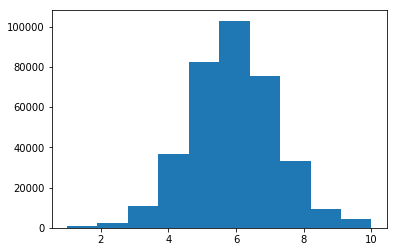

In [34]:
##応答変数を変換
y = np.round(y0)
y[y > 10] = 10.0; y[y < 1] = 1
plt.hist(y)

In [35]:
##テストデータを作成
#IDを作成
pt_test = np.random.poisson(np.random.gamma(20.0, 1/0.3, item), item); pt_test[pt_test < 2] = 2
item_id_test = np.repeat(range(item), pt_test)
pt_id_test = np.array(list(itertools.chain(*[np.array(range(pt_test[i]), dtype="int") for i in range(item)])))

#タグを設定
tag_id_test0 = np.zeros((np.sum(pt_test), max_n), dtype="int") 
for j in range(item):
    x = tag_list[j]
    index = np.array(np.where(item_id_test==j)[0], dtype="int32")
    zeros = tag + np.zeros((index.shape[0], max_n-x.shape[0]), dtype=int)
    tag_id_test0[index, ] = np.hstack((np.repeat(x-1, index.shape[0]).reshape(index.shape[0], x.shape[0], order="F"), zeros))

#交互作用の特徴ベクトルを生成
index_n_test = np.array(np.where(np.sum(tag_id_test0!=tag, axis=1) >= 2)[0], dtype="int")
WH = np.zeros(np.sum(pt_test))
for j in range(combine_n.shape[0]):
    W = theta_g0[tag_id_test0[index_n_test, j], ]
    H = np.sum(theta_g0[tag_id_test0[index_n_test, ][:, combine_list[j]]], axis=1)
    WH[index_n_test] += np.dot(W * H, vec_k)
    
#応答変数を生成
mu = beta + theta_v[item_id_test] + np.dot(np.append(theta_r, 0)[tag_id_test0], np.repeat(1, max_n)) + WH   #期待値を設定
y0 = np.random.normal(mu, Sigma, np.sum(pt_test))

##応答変数を変換
y_test = np.round(y0)
y_test[y_test > 10] = 10.0; y_test[y_test < 1] = 1

In [36]:
####Bayesian SFMを推定####
##アルゴリズムの設定
R = 2000
burnin = 500
keep = 2
disp = 10
iter = 0

In [37]:
##事前分布の設定
#回帰パラメータの事前分布
alpha1 = 0
alpha2 = np.zeros(column_v)
alpha3 = np.zeros(k)

#分散の事前分布
s0 = 0.1
v0 = 0.1
nu = 1   #逆ウィシャート分布の自由度
V = 0.01 * np.diag(np.repeat(1, k))   #逆ウィシャート分布のパラメータ
tau1 = 100
tau2 = 100 * np.diag(np.repeat(1, column_v))
inv_tau2 = np.linalg.inv(tau2)
tau3 = 100 * np.diag(np.repeat(1, k))
inv_tau3 = np.linalg.inv(tau3)

In [38]:
##パラメータの真値
#階層モデルのパラメータの真値
alpha_v = alpha_vt.copy()
tau_v = tau_vt.copy()
alpha_mu = np.dot(v, alpha_v)
tau_r = tau_rt.copy()
tau_g = tau_gt.copy()
inv_tau_g = np.linalg.inv(tau_g)

#モデルパラメータの真値
beta = betat
Sigma = Sigmat 
theta_v = theta_vt.copy()
theta_r = theta_rt.copy()
theta_g = theta_gt.copy()
theta_g0 = np.vstack((theta_g, np.repeat(0, k)))

#交互作用の特徴ベクトルの真値
theta_vec1 = theta_v[item_id]
theta_vec2 = np.dot(np.append(theta_r, 0)[tag_id0], np.repeat(1, max_n))
WH = np.zeros(N)
for j in range(combine_n.shape[0]):
    W = theta_g0[tag_id0[index_n, j], ]
    H = np.sum(theta_g0[tag_id0[index_n, ][:, combine_list[j]]], axis=1)
    WH[index_n] += np.dot(W * H, vec_k)

In [39]:
##パラメータの初期値
#階層モデルのパラメータの初期値
alpha_v = np.random.uniform(-0.5, 0.5, column_v)
tau_v = 0.2
alpha_mu = np.dot(v, alpha_v)
tau_r = 0.2
tau_g = 0.1 * np.diag(np.repeat(1, k))
inv_tau_g = np.linalg.inv(tau_g)

#モデルパラメータの初期値
beta = 5.5
Sigma = 1.0
theta_v = np.random.normal(alpha_mu, tau_v, item)
theta_r = np.random.normal(0, tau_r, tag)
theta_g = np.random.multivariate_normal(np.repeat(0, k), tau_g, tag)
theta_g0 = np.vstack((theta_g, np.repeat(0, k)))

#交互作用の特徴ベクトルの真値
theta_vec1 = theta_v[item_id]
theta_vec2 = np.dot(np.append(theta_r, 0)[tag_id0], np.repeat(1, max_n))
WH = np.zeros(N)
for j in range(combine_n.shape[0]):
    W = theta_g0[tag_id0[index_n, j], ]
    H = np.sum(theta_g0[tag_id0[index_n, ][:, combine_list[j]]], axis=1)
    WH[index_n] += np.dot(W * H, vec_k)

In [40]:
##データとインデックスを設定
#インデックスを設定
tag_list1 = [i for i in range(tag)]; tag_list2 = [i for i in range(tag)]
tag_n1 = np.zeros(tag); tag_n2 = np.zeros(tag)
for i in range(tag):
    index1 = np.array([], dtype="int32"); index2 = np.array([], dtype="int32")
    for j in range(max_n):
        index1 = np.append(index1, np.array(np.where(tag_id0[:, j]==i)[0], dtype="int32"))
        index2 = np.append(index2, index_n[np.where(tag_id0[index_n, j]==i)[0]])
    tag_list1[i] = np.sort(index1)
    tag_list2[i] = np.sort(index2)
    tag_n1[i] = tag_list1[i].shape[0]
    tag_n2[i] = tag_list2[i].shape[0]

In [41]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
LLst = np.sum(scipy.stats.norm.logpdf(y_test, np.mean(y_test), np.std(y_test)))

#真値での対数尤度
#交互作用の特徴ベクトルを設定
theta_gt0 = np.vstack((theta_gt, np.repeat(0, k)))
WH_test = np.zeros(np.sum(pt_test))
for j in range(combine_n.shape[0]):
    W = theta_gt0[tag_id_test0[index_n_test, j], ]
    H = np.sum(theta_gt0[tag_id_test0[index_n_test, ][:, combine_list[j]]], axis=1)
    WH_test[index_n_test] += np.dot(W * H, vec_k)
    
#対数尤度の和を計算
mu = betat + theta_vt[item_id_test] + np.dot(np.append(theta_rt, 0)[tag_id_test0], np.repeat(1, max_n)) + WH_test   #期待値を設定
LLbest = np.sum(scipy.stats.norm.logpdf(y_test, mu, Sigmat))

In [42]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##モデル平均のパラメータをサンプリング
    #モデル誤差を設定
    er = y - theta_vec1 - theta_vec2 - WH

    #正規分布のパラメータ
    omega = (N/np.power(Sigma, 2)) / (1/tau1 + N/np.power(Sigma, 2))   #重み係数
    beta_mu = omega * np.mean(er)   #正規分布の平均
    Cov = 1 / (1/tau1 + N/np.power(Sigma, 2))   #正規分布の標準偏差

    #正規分布からパラメータをサンプリング
    beta = np.random.normal(beta_mu, Cov, 1)

    ##モデルの標準偏差をサンプリング
    #モデル誤差を設定
    er <- y - beta - theta_vec1 - theta_vec2 - WH

    #逆ガンマ分布のパラメータ
    s1 = np.sum(np.power(er - np.mean(er), 2))
    v1 = N + v0

    #逆ガンマ分布から標準偏差をサンプリング
    Sigma = np.sqrt(1/np.random.gamma(v1/2, 1/(s1/2), 1))


    ##アイテムの変量効果をサンプリング
    #モデル誤差を設定
    er = y - beta - theta_vec2 - WH

    #正規分布のパラメータ
    omega = (pt/np.power(Sigma, 2)) / (1/np.power(tau_v, 2) + pt/np.power(Sigma, 2))   #重み係数
    Cov = 1 / (1/np.power(tau_v, 2) + pt/np.power(Sigma, 2))   #正規分布の標準偏差
    theta_mu = np.zeros(item)
    for j in range(item):
        theta_mu[j] = (1-omega[j])*alpha_mu[j] + omega[j]*np.mean(er[item_list[j]])

    #正規分布からパラメータをサンプリング
    theta_v = np.random.normal(theta_mu, Cov, item)
    theta_vec1 = theta_v[item_id]

    
    ##アイテムタグの変量効果をサンプリング
    #モデル誤差を設定
    er = y - beta - theta_vec1 - WH
    alpha_mu = np.dot(v, alpha_v)

    #正規分布のパラメータ
    omega = (tag_n1/np.power(Sigma, 2)) / (1/np.power(tau_r, 2) + tag_n1/np.power(Sigma, 2))   #重み係数
    Cov = 1 / (1/np.power(tau_r, 2) + tag_n1/np.power(Sigma, 2))   #正規分布の標準偏差
    theta_mu = np.zeros(tag)

    for j in range(tag):
        #サンプリング対象外のアイテムタグの変量効果
        theta_r0 = np.append(theta_r, 0); theta_r0[j] = 0
        r = np.dot(theta_r0[tag_id0[tag_list1[j], ], ], np.repeat(1, max_n))

        #正規分布の平均
        er_y = er[tag_list1[j]] - r
        theta_mu[j] = omega[j] * np.mean(er_y)

    #正規分布からパラメータをサンプリング
    theta_r = np.random.normal(theta_mu, Cov, tag)
    theta_vec2 = np.dot(np.append(theta_r, 0)[tag_id0], np.repeat(1, max_n))


    ##交互作用の特徴ベクトルをサンプリング
    #モデル誤差を設定
    er = y - beta - theta_vec1 - theta_vec2

    for i in range(tag):
        #データの設定
        theta_g0 = np.vstack((theta_g, np.repeat(0, k))); theta_g0[i, ] = np.repeat(0, k)
        index = tag_list2[i]
        tag_vec = tag_id0[index, ]

        #サンプリング対象外の交互作用ベクトルのパラメータ
        wh = np.zeros((index.shape[0]))
        for j in range(combine_n.shape[0]):
            w = theta_g0[tag_vec[:, j], ]
            h = np.sum(theta_g0[tag_vec[:, combine_list[j]], ], axis=1)
            wh += np.dot(w * h, vec_k)

        #多変量正規分布のパラメータ
        er_y = er[index] - wh
        x = np.sum(theta_g0[tag_vec, ], axis=1)
        inv_xxv = np.linalg.inv(np.dot(x.T, x) + inv_tau_g)
        theta_mu = np.dot(np.dot(inv_xxv, x.T), er_y)   #多変量正規分布の平均ベクトル
        Cov = np.power(Sigma, 2) * inv_xxv   #多変量正規分布の分散

        #多変量正規分布からパラメータをサンプリング
        theta_g[i, ] = np.random.multivariate_normal(theta_mu, Cov, 1)

    #交互作用の期待値を更新
    theta_g0 = np.vstack((theta_g, np.repeat(0, k)))
    WH = np.zeros(N)
    for j in range(combine_n.shape[0]):
        W = theta_g0[tag_id0[index_n, j], ]
        H = np.sum(theta_g0[tag_id0[index_n, ][:, combine_list[j]]], axis=1)
        WH[index_n] += np.dot(W * H, vec_k)


    ##アイテムの変量効果の階層モデルのパラメータをサンプリング
    #線形回帰モデルの回帰パラメータをサンプリング
    inv_xxv = np.linalg.inv(np.dot(v.T, v) + inv_tau2)
    mu = np.dot(np.dot(inv_xxv, v.T), theta_v)
    alpha_v = np.random.multivariate_normal(mu, tau_v*inv_xxv)
    alpha_mu = np.dot(v, alpha_v)

    #逆ガンマ分布から分散をサンプリング
    er = theta_v - alpha_mu
    s1 = np.dot(er.T, er) + s0
    v1 = item + v0
    tau_v = np.sqrt(1/np.random.gamma(v1/2, 1/(s1/2), 1))
    inv_tau_v = 1 / tau_v

    ##タグの変量効果の階層モデルのパラメータをサンプリング
    #逆ガンマ分布から分散をサンプリング
    s1 = np.dot(theta_r.T, theta_r) + s0
    v1 = tag + v0
    tau_r = np.sqrt(1/np.random.gamma(v1/2, 1/(s1/2), 1))
    inv_tau_r = 1 / tau_r

    ##タグの特徴ベクトルの階層モデルのパラメータをサンプリング
    #逆ウィシャート分布から分散をサンプリング
    IW_R = np.dot(theta_g.T, theta_g) + V
    Sn = tag + nu
    tau_g = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_tau_g = np.linalg.inv(tau_g)


    ##パラメータの格納とサンプリング結果の表示
    if rp%keep==0:
        #パラメータを格納
        mkeep = rp//keep

    if rp%disp==0:
        ##テストデータの対数尤度を更新
        #交互作用の特徴ベクトルを設定
        WH_test = np.zeros(np.sum(pt_test))
        for j in range(combine_n.shape[0]):
            W = theta_g0[tag_id_test0[index_n_test, j], ]
            H = np.sum(theta_g0[tag_id_test0[index_n_test, ][:, combine_list[j]]], axis=1)
            WH_test[index_n_test] += np.dot(W * H, vec_k)

        #対数尤度の和を計算
        mu = beta + theta_v[item_id_test] + np.dot(np.append(theta_r, 0)[tag_id_test0], np.repeat(1, max_n)) + WH_test   #期待値を設定
        LL = np.sum(scipy.stats.norm.logpdf(y_test, mu, Sigma))

        #対数尤度とサンプリング結果を表示
        print(rp)
        print(np.round(np.array([LL, LLst, LLbest]), 1))
        print(np.round([beta[0], betat], 3))

0
[-289292.3 -359102.4 -180931.4]
[5.495 5.5  ]
10
[-174654.  -359102.4 -180931.4]
[5.514 5.5  ]
20
[-174654.7 -359102.4 -180931.4]
[5.514 5.5  ]
30
[-174662.7 -359102.4 -180931.4]
[5.512 5.5  ]
40
[-174707.2 -359102.4 -180931.4]
[5.512 5.5  ]
50
[-174567.6 -359102.4 -180931.4]
[5.513 5.5  ]
60
[-174490.  -359102.4 -180931.4]
[5.517 5.5  ]
70
[-174507.2 -359102.4 -180931.4]
[5.519 5.5  ]
80
[-174498.5 -359102.4 -180931.4]
[5.519 5.5  ]
90
[-174458.6 -359102.4 -180931.4]
[5.524 5.5  ]
100
[-174403.6 -359102.4 -180931.4]
[5.527 5.5  ]
110
[-174407.7 -359102.4 -180931.4]
[5.528 5.5  ]
120
[-174408.6 -359102.4 -180931.4]
[5.529 5.5  ]
130
[-174405.8 -359102.4 -180931.4]
[5.53 5.5 ]
140
[-174407.7 -359102.4 -180931.4]
[5.531 5.5  ]
150
[-174396.8 -359102.4 -180931.4]
[5.531 5.5  ]
160
[-174410.  -359102.4 -180931.4]
[5.531 5.5  ]
170
[-174409.8 -359102.4 -180931.4]
[5.532 5.5  ]
180
[-174412.8 -359102.4 -180931.4]
[5.532 5.5  ]
190
[-174402.7 -359102.4 -180931.4]
[5.533 5.5  ]
200
[-174403.

1630
[-174412.7 -359102.4 -180931.4]
[5.544 5.5  ]
1640
[-174417.6 -359102.4 -180931.4]
[5.544 5.5  ]
1650
[-174409.8 -359102.4 -180931.4]
[5.544 5.5  ]
1660
[-174402.7 -359102.4 -180931.4]
[5.544 5.5  ]
1670
[-174418.7 -359102.4 -180931.4]
[5.544 5.5  ]
1680
[-174409.6 -359102.4 -180931.4]
[5.544 5.5  ]
1690
[-174408.1 -359102.4 -180931.4]
[5.544 5.5  ]
1700
[-174407.6 -359102.4 -180931.4]
[5.544 5.5  ]
1710
[-174407.1 -359102.4 -180931.4]
[5.544 5.5  ]
1720
[-174407.8 -359102.4 -180931.4]
[5.544 5.5  ]
1730
[-174407.3 -359102.4 -180931.4]
[5.544 5.5  ]
1740
[-174408.3 -359102.4 -180931.4]
[5.544 5.5  ]
1750
[-174400.9 -359102.4 -180931.4]
[5.544 5.5  ]
1760
[-174412.8 -359102.4 -180931.4]
[5.544 5.5  ]
1770
[-174415.1 -359102.4 -180931.4]
[5.544 5.5  ]
1780
[-174405.2 -359102.4 -180931.4]
[5.544 5.5  ]
1790
[-174410.9 -359102.4 -180931.4]
[5.544 5.5  ]
1800
[-174407.1 -359102.4 -180931.4]
[5.544 5.5  ]
1810
[-174414.3 -359102.4 -180931.4]
[5.544 5.5  ]
1820
[-174402.5 -359102.4 -1809